In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [4]:
# Load the data from csv file
def get_data_frame_from_csv(file_path='../train.csv'):
    df = pd.read_csv(file_path)
    return df

In [4]:
# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
# http://nlp.town/blog/sentence-similarity/
#https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XW6mnS2B3_Q
#http://sujitpal.blogspot.com/2015/09/sentence-similarity-using-word2vec-and.html
#https://medium.com/@adriensieg/text-similarities-da019229c894
#https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

<h3> Basic Structure</h3>

In [5]:
data_frame = get_data_frame_from_csv()

In [6]:
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

__There are four columns id, qid1,qid2,question1,question2, is_duplicate__.
<ul>
    <li>id: It is unique id for eacch data coulmn</li>
    <li>qid1: It denotes the id for question 1</li>
    <li>qid2: It denotes the id for question 2</li>
    <li>question1: Question 1 string</li>
    <li>question2: Question 2 String</li>
</ul>

In [7]:
data_frame.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [8]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


__Observation: There are Total 404290 number of rows. There are two question missing from question 2__.

<h3>EDA</h3>

In [9]:
# Print Number of duplicate questions
print('Number of duplicate questions = {}'.format(len(data_frame[data_frame['is_duplicate']==1].index)))
# print number of non dupliccate questions pair
print('Number of non duplicate question pair = {}'.format(len(data_frame[data_frame['is_duplicate']==0].index)))

Number of duplicate questions = 149263
Number of non duplicate question pair = 255027


In [10]:
print('% of question pair not similar = {}%'.format(100-round(data_frame['is_duplicate'].mean()*100,2)))
print('% of question pair similar = {}%'.format(round(data_frame['is_duplicate'].mean()*100,2)))

% of question pair not similar = 63.08%
% of question pair similar = 36.92%


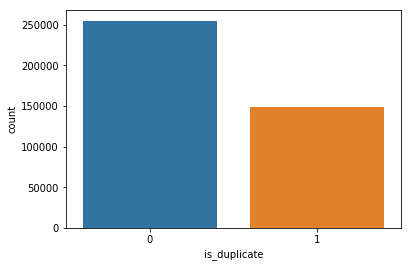

In [11]:
# Number of dubliccate questions plot
sns.countplot(data_frame['is_duplicate'])

__Observation: There are More number of question pairs which are not duplicate__

<h4>Number of Unique Questions</h4>

In [12]:
qids = pd.Series(data_frame['qid1'].tolist()+data_frame['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_more_than_one_time = np.sum(qids.value_counts()>1)
print('Total Number of Unique Question = {}'.format(unique_qs))
print('Number of unique question that appear more than one time={}'.format(qs_more_than_one_time))
print('Maximum number of time a single question repeated = {}'.format(np.max(qids.value_counts())))

Total Number of Unique Question = 537933
Number of unique question that appear more than one time=111780
Maximum number of time a single question repeated = 157


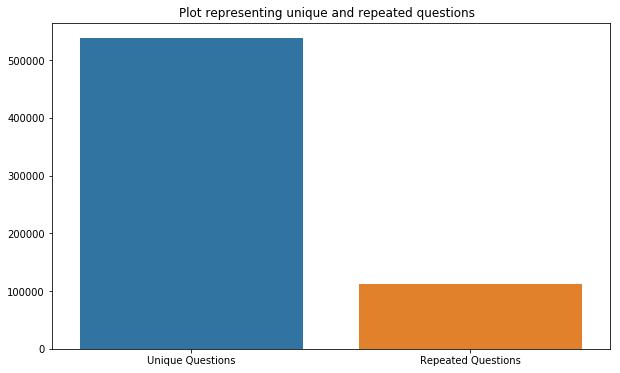

In [13]:
x = ['Unique Questions','Repeated Questions']
y = [unique_qs, qs_more_than_one_time]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>Checking Pair duplicate<h3>

In [14]:
# Checkcing pair duplicacy
pair_duplicate = data_frame[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
number_pair_duplicate = pair_duplicate.shape[0]-data_frame.shape[0]
print('Number of duplicate pair = {}'.format(number_pair_duplicate))

Number of duplicate pair = 0


__Observation : There are no any pairs which are duplicate__.

<h3>Number of Occurance of each question</h3>

maximum number of time a single question occurs = 157


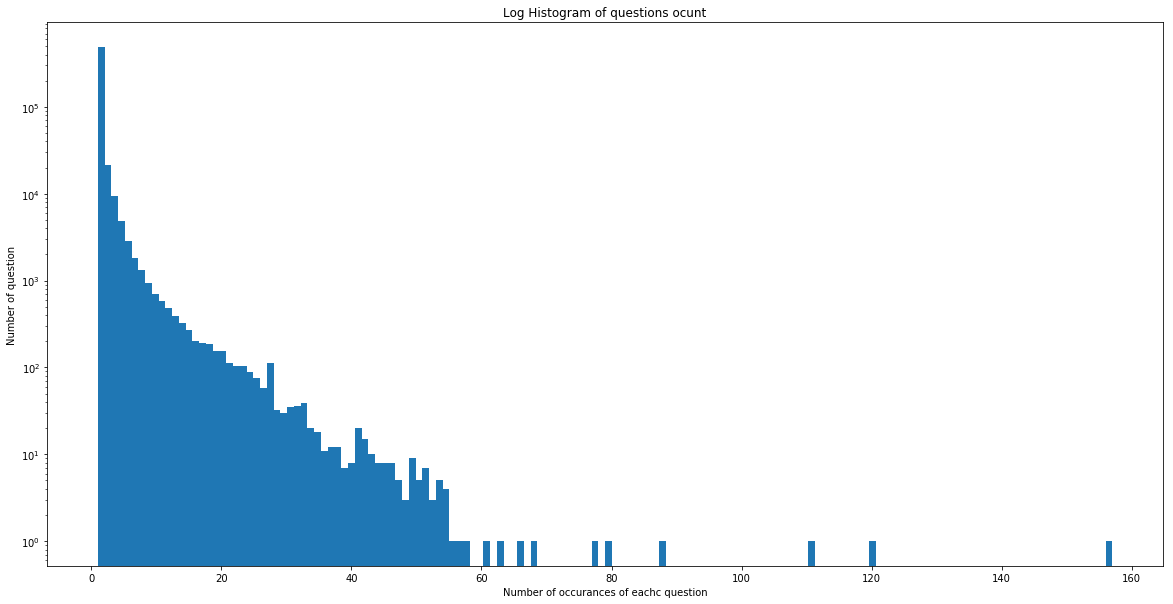

In [15]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=150)
plt.yscale('log',nonposy='clip')
plt.title('Log Histogram of questions ocunt')
plt.xlabel('Number of occurances of eachc question')
plt.ylabel('Number of question')
print('maximum number of time a single question occurs = {}'.format(np.max(qids.value_counts())))

__Observation : From the above histogram more number of questions appear single time and one question which appear maximum number of time i.e 156__.

In [16]:
# Rows having any one feature is null
null_feature_row = data_frame[data_frame.isnull().any(1)]
null_feature_row

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

__Observation : There are three rows having atleast one feature value is null__.

In [17]:
# Fill null value with empty string
data_frame = data_frame.fillna(' ')
data_frame[data_frame.isnull().any(1)]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

In [18]:
# data_frame['question1'][-50:-1]

In [19]:
# To see the questions text
#  question1 text
first_50_question1_text = ' '.join(data_frame['question1'][:50])
last_50_question1_text = ' '.join(data_frame['question1'][-50:-1])
# Question2 text
first_50_question2_text = ' '.join(data_frame['question2'][:50])
last_50_question2_text = ' '.join(data_frame['question2'][-50:-1])

print('+++++++++++++++++++++First 50 Question1++++++++++++++++++')
print(first_50_question1_text)
print('+++++++++++++++++++++Last 50 question1++++++++++++++++++++')
print(last_50_question1_text)
print('+++++++++++++++++++++First 50 Question2++++++++++++++++++')
print(first_50_question2_text)
print('+++++++++++++++++++++Last 50 question2++++++++++++++++++++')
print(last_50_question2_text)

+++++++++++++++++++++First 50 Question1++++++++++++++++++
What is the step by step guide to invest in share market in india? What is the story of Kohinoor (Koh-i-Noor) Diamond? How can I increase the speed of my internet connection while using a VPN? Why am I mentally very lonely? How can I solve it? Which one dissolve in water quikly sugar, salt, methane and carbon di oxide? Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? Should I buy tiago? How can I be a good geologist? When do you use シ instead of し? Motorola (company): Can I hack my Charter Motorolla DCX3400? Method to find separation of slits using fresnel biprism? How do I read and find my YouTube comments? What can make Physics easy to learn? What was your first sexual experience like? What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada? What would a Trump presidency mean for current international mast

<h3>Cleaning Text</h3>

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

In [21]:
# Helper functions
# Text data is the list of words
#@ Return the text data (List of word)
def get_text_without_stop_words(text_data,stop_words=None):
    if not stop_words is None:
        text_data = [word for word in text_data if not word in stop_words]
    return text_data

# Get text without punctuations
def get_text_without_punctiuation(text_data,punctuations):
    re_punc = re.compile('[%s]' %re.escape(punctuations))
    text_data = [re_punc.sub('',word) for word in text_data]
    return text_data
#Get Text data with only alphabatci data 
def get_text_without_number(text_data):
    text_data = [word for word in text_data if word.isalpha()]
    return text_data
# Remove Html Tags from text 
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
def remove_html_tags(text):
    tag_re = re.compile('<.*?>')
    text = re.sub(tag_re,' ',text)
    return text.strip()
# replace currency symbol text
def map_country_currency_country_name(text):
    text = text.replace('%',' percent')
    text = text.replace('₹',' reupee ')
    text = text.replace('$',' dollar ')
    text = text.replace("€", " euro ")
    return text.strip()
def map_numeric_to_units(text):
    text = re.sub(r"([0-9]+)000000",r"\1m",text)
    text = re.sub(r"([0-9]+)000",r"\1k",text)
    return text
def remove_dots_and_colon(text):
    text = re.sub(r'\.+', " ", text)
    text = text.strip()
    text = text.replace(":",' ')
    return text
# Normalise text 
def normalize_text(text):
    return text.lower()
# Use Stemmer to stem the word
def steming_text(text,stemmer):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [22]:
# map_country_currency_country_name('I have $10 only')
# map_numeric_to_units('this is 1000000')
# stemmer  = PorterStemmer()
# steming_text('I have 10000 playing',stemmer)

In [23]:
# Decontraction of text
contractions_dict = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how're": "how are",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "İ've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you shall have",
    "you're": "you are",
    "you've": "you have",
}
# @Parameter text is string
#https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
def de_contract_text(text):
    contraction_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),flags = re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match)\
                                if contractions_dict.get(match)\
                                else contractions_dict.get(match.lower())   
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    text = contraction_pattern.sub(expand_match, text)
    text = re.sub("'", "", text)
    return text
# de_contract_text("Y'all can't expand contractions I'd think")
# de_contract_text("How can i lose weight if i'm 110kgs?")

In [24]:
def preprocess():
    # Deccontract the Question1 and Question2
    data_frame['question1'] = data_frame['question1'].apply(lambda text: de_contract_text(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: de_contract_text(text))
    # Replace Question Marks
    # We assumen that if there is any thing placed in quora it is a questopn
    data_frame['question1'] = data_frame['question1'].apply(lambda text: text.replace('?',''))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: text.replace('?',''))
    data_frame['question1'] = data_frame['question1'].apply(lambda text: remove_dots_and_colon(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: remove_dots_and_colon(text))
    # Remove Html Tags
    data_frame['question1'] = data_frame['question1'].apply(lambda text: remove_html_tags(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: remove_html_tags(text))
    #Map Cucrrencyc to english word
    data_frame['question1'] = data_frame['question1'].apply(lambda text: map_country_currency_country_name(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: map_country_currency_country_name(text))
    # Map large Number to some denomination units
    data_frame['question1'] = data_frame['question1'].apply(lambda text: map_numeric_to_units(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: map_numeric_to_units(text))
    # Normalise Texts
    data_frame['question1'] = data_frame['question1'].apply(lambda text: normalize_text(text))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: normalize_text(text))
    # Stemming Text
    stemmer = PorterStemmer()
    data_frame['question1'] = data_frame['question1'].apply(lambda text: steming_text(text,stemmer))
    data_frame['question2'] = data_frame['question2'].apply(lambda text: steming_text(text,stemmer))

In [25]:
preprocess()

In [26]:
# print 10 question from question1 and 10 question from question2
' '.join(data_frame['question1'][0:10])

'what is the step by step guid to invest in share market in india what is the stori of kohinoor (koh-i-noor) diamond how can i increas the speed of my internet connect while use a vpn whi am i mental veri lone how can i solv it which one dissolv in water quikli sugar, salt, methan and carbon di oxid astrolog i am a capricorn sun cap moon and cap rise what doe that say about me should i buy tiago how can i be a good geologist when do you use シ instead of し motorola (company) can i hack my charter motorolla dcx3400'

In [27]:
# Print 10 questions from question2
' '.join(data_frame['question2'][0:10])

'what is the step by step guid to invest in share market what would happen if the indian govern stole the kohinoor (koh-i-noor) diamond back how can internet speed be increas by hack through dn find the remaind when [math]23^{24}[/math] is divid by 24,23 which fish would surviv in salt water i am a tripl capricorn (sun, moon and ascend in capricorn) what doe thi say about me what keep childern activ and far from phone and video game what should i do to be a great geologist when do you use "&" instead of "and" how do i hack motorola dcx3400 for free internet'

In [28]:
# Import Gensim
import gensim
from gensim.models import word2vec
import os

<h3>Basic Feature Extraction</h3>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [29]:
def get_word_list_of_text(text):
    text = str(text).lower()
    texts = text.split()
    return texts

def get_num_word(text):
    return len(get_word_list_of_text(text))

def common_word(row):
    q1_words = set(get_word_list_of_text(row['question1']))
    q2_words = set(get_word_list_of_text(row['question2']))
    return len(q1_words.intersection(q2_words))

def get_total_word(row):
    q1_words = set(get_word_list_of_text(row['question1']))
    q2_words = set(get_word_list_of_text(row['question2']))
    return (len(q1_words)+len(q2_words))
def get_num_of_share_word(row):
    q1_words = set(get_word_list_of_text(row['question1']))
    q2_words = set(get_word_list_of_text(row['question2']))
    num_share_word = 1

In [30]:
if os.path.isfile('clean_basic_feature_df_train.csv'):
    data_frame = pd.read_csv('clean_basic_feature_df_train.csv')
else:
    data_frame['freq_qid1'] = data_frame.groupby('qid1')['qid1'].transform('count')
    data_frame['frew_qid2'] = data_frame.groupby('qid2')['qid2'].transform('count')
    data_frame['q1len'] = data_frame['question1'].str.len()
    data_frame['q2len'] = data_frame['question2'].str.len()
    data_frame['q1_n_words'] = data_frame['question1'].apply(lambda question: get_num_word(question))
    data_frame['q2_n_words'] = data_frame['question2'].apply(lambda question: get_num_word(question))
    data_frame['word_common'] = data_frame.apply(common_word,axis=1)
    data_frame['word_total'] = data_frame.apply(get_total_word,axis=1)
    

In [31]:
data_frame[data_frame['qid1']==3]

id  qid1    qid2  \
1            1     3       4   
184732  184732     3  282170   
263614  263614     3  380197   
359232  359232     3  488853   

                                                question1  \
1       what is the stori of kohinoor (koh-i-noor) dia...   
184732  what is the stori of kohinoor (koh-i-noor) dia...   
263614  what is the stori of kohinoor (koh-i-noor) dia...   
359232  what is the stori of kohinoor (koh-i-noor) dia...   

                                                question2  is_duplicate  \
1       what would happen if the indian govern stole t...             0   
184732                 is it possibl to melt down diamond             0   
263614  what are some interest fact about kohinoor dia...             0   
359232               could india keep the koh-i-noor safe             0   

        freq_qid1  frew_qid2  q1len  q2len  q1_n_words  q2_n_words  \
1               4          1     50     83           8          13   
184732          4          1     50     34           8           7   
263614          4          1     50     50           8           8   
359232          4          1     50     36           8           6   

        word_common  word_total  
1                 5          20  
184732            2          15  
263614            3          16  
359232            1          14

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [62]:
# Get the features using question1 and question 2
STOP_WORDS = stopwords.words("english")
SAFE_DIV = 0.0001 
# Get List of words from text
def get_word_list_from_text(text):
    return str(text).split()
# Get non stop words
def get_words_set(tokens,is_stopwords = True):
    if is_stopwords:
        non_stop_tokens = set([word for word in tokens if word not in STOP_WORDS])
    else:
        non_stop_tokens = set([word for word in tokens if word in STOP_WORDS])
    return non_stop_tokens
# Get common Words
def get_common_count(words1,words2):
    words1 = set(words1)
    words2 = set(words2)
    common_words = words1.intersection(words2)
    return len(common_words)

def get_token_featres(q1,q2):
    token_fetaures = {
        'cwc_min' : 0.0,
        'cwc_max' : 0.0,
        'csc_min' : 0.0,
        'csc_max' : 0.0,
        'ctc_min' : 0.0,
        'ctc_max' : 0.0,
        'last_word_eq' : 0.0,
        'first_word_eq' : 0.0,
        'abs_len_diff' : 0.0,
        'mean_len' : 0.0
    }
    q1_tokens = get_word_list_from_text(q1)
    q2_tokens = get_word_list_from_text(q2)
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_fetaures
    # Get Non stop words set from tokens
    q1_words = get_words_set(q1_tokens)
    q2_words = get_words_set(q2_tokens)
    # Get Stop words set
    q1_stop = get_words_set(q1_tokens,is_stopwords=False)
    q2_stop = get_words_set(q2_tokens,is_stopwords=False)
    # Get common words
    common_words_count = get_common_count(q1_words,q2_words)
    #Common Stop words
    common_stops_count = get_common_count(q1_stop,q2_stop)
    #common_token count
    common_token_count = get_common_count(q1_tokens,q2_tokens)
    # Calculation for cwc_min
    cwc_min = common_words_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    cwc_max = common_words_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    csc_min = common_stops_count/(min(len(q1_stop),len(q2_stop))+SAFE_DIV)
    csc_max = common_stops_count/(max(len(q1_stop),len(q2_stop))+SAFE_DIV)
    ctc_min = common_token_count/(min(len(q1_tokens),len(q2_tokens))+SAFE_DIV)
    ctc_max = common_token_count/(max(len(q1_tokens),len(q2_tokens))+SAFE_DIV)
    last_word_eq  = int(q1_tokens[-1] == q2_tokens[-1])
    first_word_eq = int(q1_tokens[0] == q2_tokens[0])
    abs_len_diff = abs(len(q1_tokens)-len(q2_tokens))
    mean_len  = (len(q1_tokens)+len(q2_tokens))/2
    token_fetaures['cwc_min'] = cwc_min
    token_fetaures['cwc_max'] = cwc_max
    token_fetaures['csc_min'] = csc_min
    token_fetaures['csc_max'] = csc_max
    token_fetaures['ctc_min'] = ctc_min
    token_fetaures['ctc_max'] = ctc_max
    token_fetaures['last_word_eq'] = last_word_eq
    token_fetaures['first_word_eq'] = first_word_eq
    token_fetaures['abs_len_diff'] = abs_len_diff
    token_fetaures['mean_len'] = mean_len
    return token_fetaures

In [95]:
# Find longest common substring 
def get_longest_substring(str1,str2):
    import collections
    row_number = len(str1)
    col_number = len(str2)
    array = [[0]*col_number for _ in range(row_number)]
    for i in range(row_number):
        for j in range(col_number):
            if str1[i] == str2[j]:
                array[i][j] = array[i-1][j-1]+1
            else:
                array[i][j] = 0
    # getting Maximum length of substring
    maximum_value_with_index = {}
    for index,item in enumerate(array):
        if len(item) == 0:
            continue
        max_val_item = max(item)
        index_sub = item.index(max_val_item)
        maximum_value_with_index[str(index)+'_'+str(index_sub)] = max_val_item
    sorted_maximum_value_with_index = sorted(maximum_value_with_index.items(), key=lambda kv: kv[1],reverse=True)
    if len(sorted_maximum_value_with_index) > 0:
         maximum_substring_length = sorted_maximum_value_with_index[0][1]
    else:
        maximum_substring_length = 0
        return maximum_substring_length,""
    # get Substring sequence
    sub_string = ""
    prev_val = -1
    for item in sorted_maximum_value_with_index:
        index_list = item[0].split("_")
        sub_list_index = int(index_list[1])
        if prev_val == -1 or (prev_val>item[1] and item[1] != 0):
            prev_val = item[1]
            sub_string+=str2[sub_list_index]
        else:
            prev_val = item[1]
    longest_substring = ''.join(reversed(sub_string))
    return maximum_substring_length,longest_substring
# get_longest_substring('abc','bcdefgabc')
# get_longest_substring('abc','def')

# Get Longest Substr ration
def get_longest_sub_str_ratio(str1,str2):
    max_sub_str_length = get_longest_substring(str1,str2)[0]
    if max_sub_str_length == 0:
        return 0
    ratio = max_sub_str_length/(min(len(str1),len(str2))+1)
    return ratio
# get_longest_sub_str_ratio('abcdef','defbcabdef')

In [96]:
get_longest_substring('abc','def')[0]

0

In [64]:
# Get Tokens Features
token_features = data_frame.apply(lambda x: get_token_featres(x['question1'],x['question2']),axis=1)
# Create the features using token features 
data_frame['cwc_min'] = list(map(lambda x: x['cwc_min'],token_features))
data_frame['cwc_max'] = list(map(lambda x: x['cwc_max'],token_features))
data_frame['csc_min'] = list(map(lambda x: x['csc_min'],token_features))
data_frame['csc_max'] = list(map(lambda x: x['csc_max'],token_features))
data_frame['ctc_min'] = list(map(lambda x: x['ctc_min'],token_features))
data_frame['ctc_max'] = list(map(lambda x: x['ctc_max'],token_features))
data_frame['last_word_eq'] = list(map(lambda x: x['last_word_eq'],token_features))
data_frame['abs_len_diff'] = list(map(lambda x: x['abs_len_diff'],token_features))
data_frame['mean_len'] = list(map(lambda x: x['mean_len'],token_features))
data_frame['first_word_eq'] = list(map(lambda x: x['first_word_eq'],token_features))

In [99]:
#Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
print("fuzzy features..")

data_frame["token_set_ratio"]       = data_frame.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
data_frame["token_sort_ratio"]      = data_frame.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
data_frame["fuzz_ratio"]            = data_frame.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
data_frame["fuzz_partial_ratio"]    = data_frame.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
data_frame["longest_substr_ratio"]  = data_frame.apply(lambda x: get_longest_substring(x["question1"], x["question2"])[0], axis=1)
data_frame["longest_substr_ratio"]  = data_frame.apply(lambda x: get_longest_sub_str_ratio(x["question1"], x["question2"]), axis=1)
data_frame["longest_substr_ratio"]  = data_frame.apply(lambda x: get_longest_sub_str_ratio(x["question1"], x["question2"]), axis=1)

fuzzy features..


In [100]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    data_frame.to_csv('nlp_features_train.csv')

In [101]:
# Total number of features
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'frew_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'first_word_eq', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [102]:
# Print some information 
data_frame.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guid to invest in sha...   
1   1     3     4  what is the stori of kohinoor (koh-i-noor) dia...   
2   2     5     6  how can i increas the speed of my internet con...   
3   3     7     8        whi am i mental veri lone how can i solv it   
4   4     9    10  which one dissolv in water quikli sugar, salt,...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guid to invest in sha...             0          1   
1  what would happen if the indian govern stole t...             0          4   
2  how can internet speed be increas by hack thro...             0          1   
3  find the remaind when [math]23^{24}[/math] is ...             0          1   
4              which fish would surviv in salt water             0          3   

   frew_qid2  q1len  q2len  ...   ctc_max  last_word_eq  abs_len_diff  \
0          1     64     55  ...  0.785709           0.0           2.0   
1          1     50     83  ...  0.384612           0.0           5.0   
2          1     66     52  ...  0.357140           0.0           4.0   
3          1     43     60  ...  0.000000           0.0           2.0   
4          1     72     37  ...  0.230767           0.0           6.0   

   mean_len  first_word_eq  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0      13.0            1.0              100                92          92   
1      10.5            1.0               86                65          68   
2      12.0            1.0               73                66          54   
3      10.0            0.0               38                37          35   
4      10.0            1.0               68                49          46   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982143  
1                  76              0.588235  
2                  56              0.188679  
3                  37              0.045455  
4                  54              0.157895  

[5 rows x 29 columns]

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [108]:
# DUplicate and Non duplicate data frame
duplicate_df = data_frame[data_frame['is_duplicate']==1]
non_duplicate_df = data_frame[data_frame['is_duplicate']==0]
# Crate text file for duplicate question1 and question2 and non duplicate too
duplicate = np.dstack([duplicate_df['question1'],duplicate_df['question2']]).flatten()
non_dplicate = np.dstack([non_duplicate_df['question1'],non_duplicate_df['question2']]).flatten()
#Saving the np array into a text file
np.savetxt('train_p.txt', duplicate, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', non_dplicate, delimiter=' ', fmt='%s')

In [109]:
print('Length of duplicate questions = {}'.format(len(duplicate)))
print('Length of non duplicate questions = {}'.format(len(non_dplicate)))

Length of duplicate questions = 298526
Length of non duplicate questions = 510054


In [113]:
# Add some word in stop words
stopword_ = set(STOP_WORDS) 
stopword_.add("said")
stopword_.add("br")
stopword_.add(" ")
stopword_.remove("not")
stopword_.remove("no")
d = path.dirname('.')
textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 14657317
Total number of words in non duplicate pair questions : 30205366


In [6]:
# Feature from avg word2vec model using google word2vec model
from gensim.models import KeyedVectors
import scipy

In [7]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

/Users/piyushnishant/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [8]:
vector = model['easy']
vector.shape

(300,)

In [154]:
word_vectors = model.wv
def get_cleaned_questions_without_stop_words(text):
    word_list = [word for word in text.split() if word not in STOP_WORDS]
    return ' '.join(word_list)
def get_avg_word_2_vec_of_sentence(text):
    cleaned = get_cleaned_questions_without_stop_words(text)
    cleaned_words = cleaned.split()
    word_vec_list = []
    for word in cleaned_words:
        if word not in word_vectors:
            continue
        word_vec_list.append(model[word])
    avg_w2vec_sentance = np.mean(word_vec_list)
    return avg_w2vec_sentance

def cosine_smilarity_two_sentences(s1,s2):
    avg_w2vec_sentance1 = get_avg_word_2_vec_of_sentence(s1)
    avg_w2vec_sentance2 = get_avg_word_2_vec_of_sentence(s2)
    if avg_w2vec_sentance1 == 0 or avg_w2vec_sentance2==0:
        return 0
    cosine = scipy.spatial.distance.cosine(avg_w2vec_sentance1, avg_w2vec_sentance2)
    return cosine

# print(get_cleaned_questions_without_stop_words(data_frame['question1'][0]))
# print(data_frame['question1'][0])
# print(get_avg_word_2_vec_of_sentence(data_frame['question1'][0]))
# print(cosine_smilarity_two_sentences(data_frame['question1'][0],data_frame['question2'][0]))
# print(data_frame['is_duplicate'][0])

In [155]:
data_frame['cosine_smilarity'] = data_frame.apply(lambda x: cosine_smilarity_two_sentences(x['question1'],x['question2']),axis=1)

In [161]:
data_frame['cosine_smilarity'].fillna(0,inplace=True)

In [175]:
# Ecludian Distance between two vectors
def get_ecludian_distnce_between_sentences(s1,s2):
    avg_w2vec_sentance1 = [get_avg_word_2_vec_of_sentence(s1)]
    avg_w2vec_sentance2 = [get_avg_word_2_vec_of_sentence(s2)]
    return np.sqrt(sum(pow(a-b,2) for a, b in zip(avg_w2vec_sentance1, avg_w2vec_sentance2)))

In [176]:
data_frame['ecludian_distance'] = data_frame.apply(lambda x: get_ecludian_distnce_between_sentences(x['question1'],x['question2']),axis=1)

In [177]:
data_frame['ecludian_distance'].fillna(0,inplace=True)

In [178]:
def man_hanton_distance(s1,s2):
    avg_w2vec_sentance1 = [get_avg_word_2_vec_of_sentence(s1)]
    avg_w2vec_sentance2 = [get_avg_word_2_vec_of_sentence(s2)]
    return sum(abs(a-b) for a,b in zip(avg_w2vec_sentance1,avg_w2vec_sentance2))

In [179]:
data_frame['man_hanton_distance'] = data_frame.apply(lambda x: man_hanton_distance(x['question1'],x['question2']),axis=1)
data_frame['man_hanton_distance'].fillna(0,inplace=True)

In [199]:
from math import sqrt
def get_sqrt_w2vec(s1,s2):
    cleaned1 = get_cleaned_questions_without_stop_words(s1)
    cleaned_words1 = cleaned1.split()
    word_vec_list1 = []
    for word1 in cleaned_words1:
        if word1 not in word_vectors:
            continue
        word_vec_list1.append(model[word1])
    
    cleaned2 = get_cleaned_questions_without_stop_words(s2)
    cleaned_words2 = cleaned2.split()
    word_vec_list2 = []
    for word2 in cleaned_words2:
        if word2 not in word_vectors:
            continue
        word_vec_list2.append(model[word2])
    sqrt1 = round(sqrt(np.sum([a*a for a in word_vec_list1])),3)
    sqrt2 = round(sqrt(np.sum([a*a for a in word_vec_list2])),3)
    return sqrt1,sqrt2


def sum_sqrt_word_vec_avg(s1,s2):
    sqrt1,sqrt2 = get_sqrt_w2vec(s1,s2)
    return sqrt1+sqrt2
def diff_sqrt_word_vec(s1,s2):
    sqrt1,sqrt2 = get_sqrt_w2vec(s1,s2)
    return sqrt1-sqrt2

In [200]:
data_frame['sqrt_sum'] = data_frame.apply(lambda x: sum_sqrt_word_vec_avg(x['question1'],x['question2']),axis=1)
data_frame['sqrt_sum'].fillna(0,inplace=True)

data_frame['sqrt_diff'] = data_frame.apply(lambda x: diff_sqrt_word_vec(x['question1'],x['question2']),axis=1)
data_frame['sqrt_diff'].fillna(0,inplace=True)

Word Cloud for Duplicate Question pairs


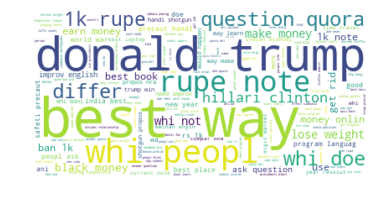

In [115]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopword_)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


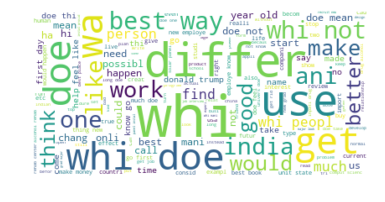

In [118]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopword_)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

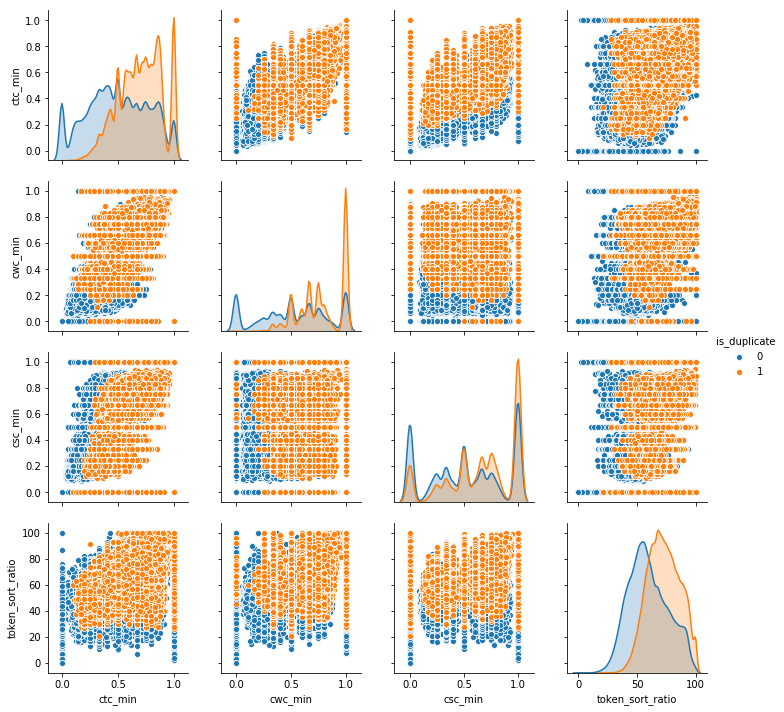

In [120]:
n = data_frame.shape[0]
sns.pairplot(data_frame[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [125]:
# data_frame[0:]

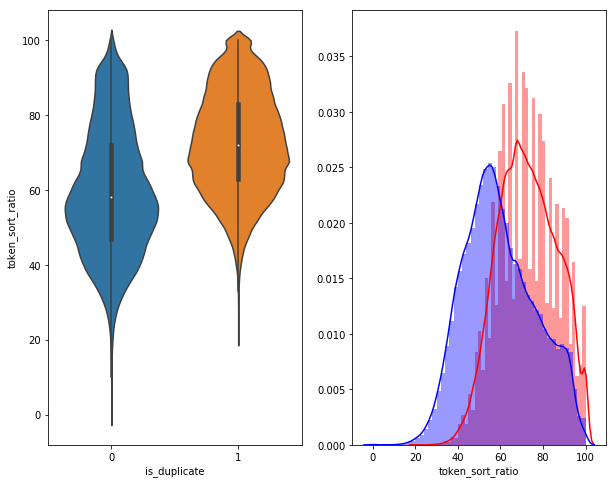

In [123]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

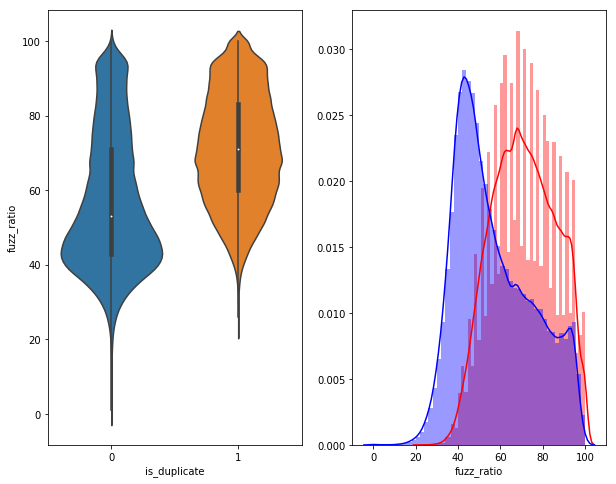

In [126]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

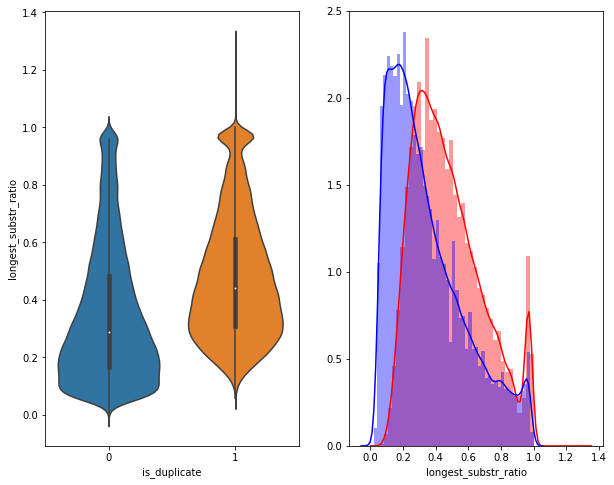

In [127]:
# longest_substr_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

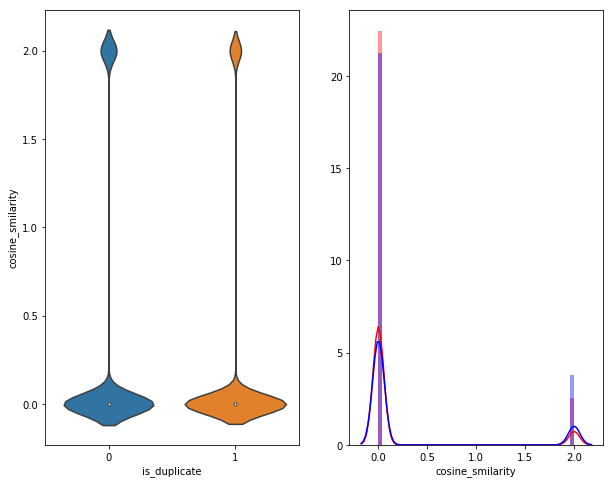

In [163]:
# Analysis of cosine_smilarity
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cosine_smilarity', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['cosine_smilarity'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['cosine_smilarity'][0:] , label = "0" , color = 'blue' )
plt.show()

__Observation : Cosine Similarity is not important features so we drop it__.

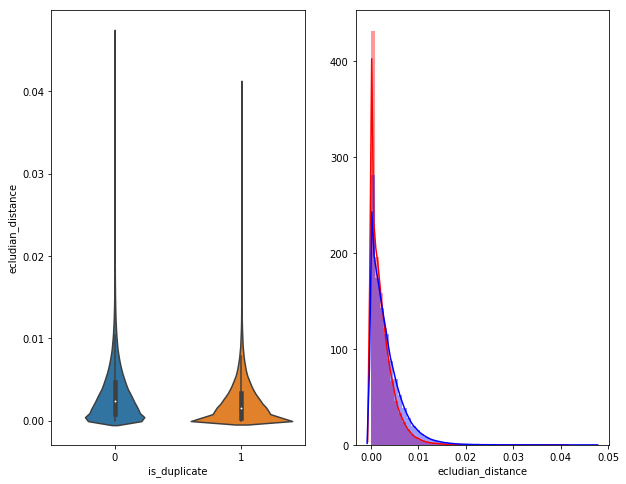

In [172]:
#ecludian_distance
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ecludian_distance', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['ecludian_distance'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['ecludian_distance'][0:] , label = "0" , color = 'blue' )
plt.show()

__Observation : The distribuation of ecludian distance is overlapping too much so we can not differentiate on the basis of ecludian distance__

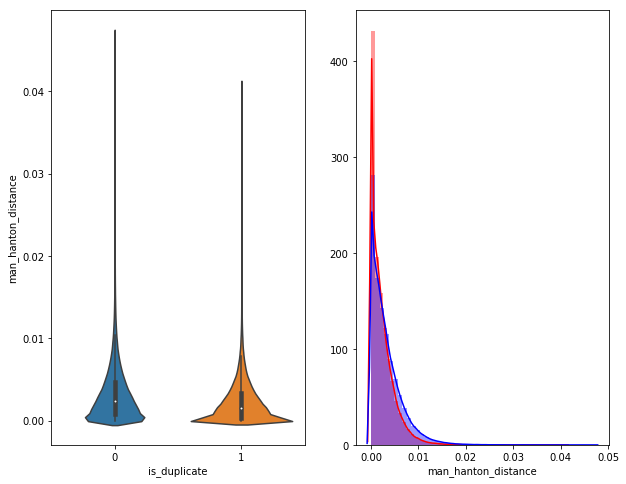

In [180]:
#  man_hanton_distance
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'man_hanton_distance', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['man_hanton_distance'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['man_hanton_distance'][0:] , label = "0" , color = 'blue' )
plt.show()

__Observation : The distribuation of ecludian distance is overlapping too much so we can not differentiate on the basis of man_hanton_distance distance__

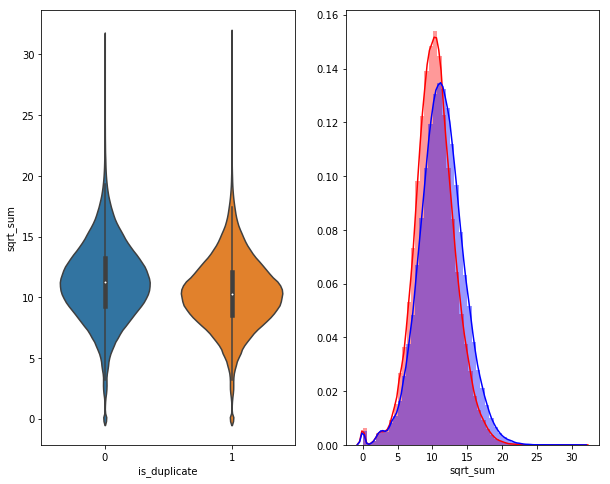

In [201]:
# sqrt_sum sqrt_diff
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'sqrt_sum', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['sqrt_sum'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['sqrt_sum'][0:] , label = "0" , color = 'blue' )
plt.show()

__Observation: from the above figure it seems that this feature is normally distributed and it is overlapping but we can take this feature in cconsideration__.

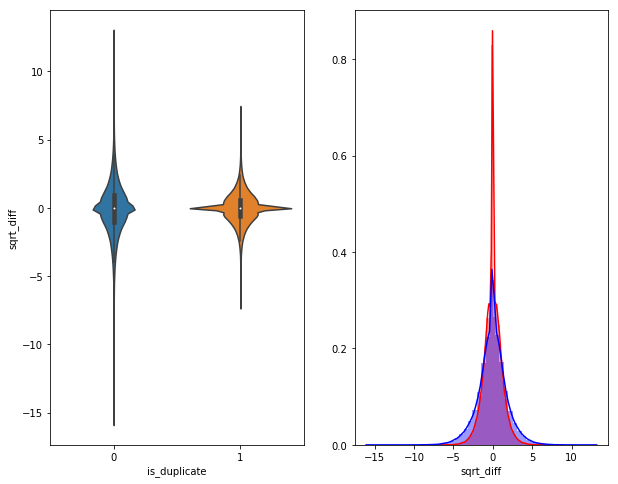

In [203]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'sqrt_diff', data = data_frame[0:] , )

plt.subplot(1,2,2)
sns.distplot(data_frame[data_frame['is_duplicate'] == 1.0]['sqrt_diff'][0:] , label = "1", color = 'red')
sns.distplot(data_frame[data_frame['is_duplicate'] == 0.0]['sqrt_diff'][0:] , label = "0" , color = 'blue' )
plt.show()

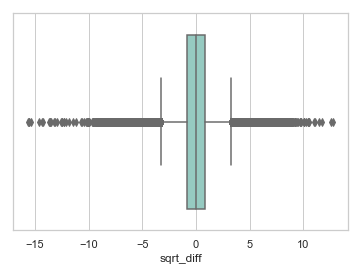

In [207]:
sns.set(style="whitegrid")
# ax = sns.boxplot(x='sqrt_diff',hue='is_duplicate',data=data_frame)
sns.boxplot(x="sqrt_diff", hue="is_duplicate",data=data_frame, palette="Set3")

__Observation: Features are more outlier and overlapping too much so we ccan ignore this features__.

In [208]:
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'frew_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'first_word_eq', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'cosine_smilarity',
       'ecludian_distance', 'man_hanton_distance', 'sqrt_sum', 'sqrt_diff'],
      dtype='object')

In [209]:
data_frame.to_csv('nlp_features_train.csv')

In [9]:
data_frame = pd.read_csv('../train.csv')

In [10]:
# Convert Question1 and quetsion2 into string
data_frame['question1'] = data_frame['question1'].apply(lambda x: str(x))
data_frame['question2'] = data_frame['question2'].apply(lambda x: str(x))

In [11]:
data_frame.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
# Use TfidfVectcorizer for calculating tfidf avg w2vecc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# List of all questions
questions = data_frame['question1']+data_frame['question2']
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
# Dicctionary with tfidf and word vecctcor
word2tfidf = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [13]:
import spacy
import tqdm

In [14]:
def get_avg_tfidf_vec_trained_glove(col_name,dataframe):
#     nlp = spacy.load('en_core_web_sm')
    word_vectors = model.wv
    vec_list = []
    for question in tqdm.tqdm(list(dataframe[col_name])):
        doc = question.split()
        mean_vec = np.zeros([len(doc),300])
#         print(len(word_vectors[doc[0]]))
#         break
        for word in doc:
            try:
                vec = word_vectors[str(word)]
                idf = word2tfidf[str(word)]
            except:
                idf = 0
                vec = 0
            mean_vec+=vec*idf
        mean_vec = mean_vec.mean(axis=0)
        vec_list.append(mean_vec)
    return list(vec_list)

In [15]:
mean_vec_list1 = get_avg_tfidf_vec_trained_glove('question1',data_frame)
# mean_vec_list2 = get_avg_tfidf_vec_trained_glove('question2',data_frame)

100%|██████████| 404290/404290 [01:15<00:00, 5383.77it/s]


In [16]:
mean_vec_list2 = get_avg_tfidf_vec_trained_glove('question2',data_frame)

100%|██████████| 404290/404290 [02:40<00:00, 2512.96it/s]


In [17]:
data_frame['q1_feats_m'] = list(mean_vec_list1)
data_frame['q2_feats_m'] = list(mean_vec_list2)

In [18]:
# data_frame.to_csv('nlp_features_train.csv')

In [19]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
#     df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [20]:
# Read Final Features from Csv and append some own usefull custom feature
# final_df = pd.read_csv('../final_features.csv')
# final_df.head()

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = data_frame.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
df1.head()

In [ ]:
df2.head()

In [ ]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

In [ ]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()